In [153]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.models import Sequential
from rdflib import ConjunctiveGraph, URIRef, RDF, RDFS, OWL, Namespace
from sklearn.metrics import confusion_matrix
import pandas as pd

from experiments.main import EKLBaseExperiment
from experiments.main import TranslationModels

%matplotlib inline

In [13]:
base_path = '/home/nether-nova/Documents/Amberg Events/routing_data/'
path_to_kg = base_path + '/Ontology/PPR_individuals_new.rdf'

CPS_NS = Namespace('http://siemens.com/knowledge_graph/cyber_physical_systems/industrial_cps#')
PPRI = Namespace('http://www.siemens.com/knowledge_graph/ppr/ind#')
PPR = Namespace('http://www.siemens.com/knowledge_graph/ppr#')
CONSISTS_OF = CPS_NS['consistsOf']

g_all = ConjunctiveGraph()
g_all.load(path_to_kg)

First, we extract all operations (i.e. PL3 entities) from the ontology.
This also includes all the 'alternatives', which are basically repeated samples for the learning algorithm. 

In [3]:
# extract process levels from knowledge graph
def pl_entities(g, e_type='train'):
    ent_list = [e for (e, lit) in g.subject_objects(PPRI[e_type])]
    return ent_list

def get_type(ent, g):
    types = list(g.objects(ent, RDF.type))
    # classes are the rdf:types of the instances (w/o OWL NI)
    types = [t for t in types if t != OWL.NamedIndividual]
    pl2_ent = list(g.subjects(CONSISTS_OF, ent))[0]
    pl2_types = [t for t in g.objects(pl2_ent, RDF.type) if t != OWL.NamedIndividual]
    pl3_ent = list(g.subjects(CONSISTS_OF, pl2_ent))[0]
    pl3_types = [t for t in g.objects(pl3_ent, RDF.type) if t != OWL.NamedIndividual]
    return (types[0], pl2_types[0], pl3_types[0])

def parse_level_3(uri_string):
    splits = uri_string.split('#')
    splits = splits[1].split('_')
    return '_'.join([l for l in splits[1:]])

pl3_train_ents = pl_entities(g_all)
pl3_test_ents = pl_entities(g_all, e_type='predict')

print "Labeled operations: ", len(pl3_train_ents)
print "Unlabeled: ", len(pl3_test_ents)
print "Example types: ", get_type(pl3_train_ents[1], g_all)

Labeled operations:  10398
Unlabeled:  11218
Example types:  (rdflib.term.URIRef(u'http://www.siemens.com/knowledge_graph/ppr#Metallische_Beschichtung_Vakuum_Labor'), rdflib.term.URIRef(u'http://www.siemens.com/knowledge_graph/ppr#Metallische_Beschichtung_Vakuum'), rdflib.term.URIRef(u'http://www.siemens.com/knowledge_graph/ppr#Metallische_Beschichtung'))


Read 73809 number of triples


Train size:  73736
Valid size:  73
Test size:  0
Num entities: 24405
Num relations: 5


Building Model


Initialized graph


	 Validation Hits10:  15.0684931507
	 Validation MeanRank:  4146.98630137
Average loss at step 11521:      13.44


	 Validation Hits10:  28.7671232877
	 Validation MeanRank:  2725.34931507
Average loss at step 23042:       6.08


	 Validation Hits10:  39.7260273973
	 Validation MeanRank:  1572.82876712
Average loss at step 34563:       4.48


	 Validation Hits10:  39.0410958904
	 Validation MeanRank:  1845.64383562
Average loss at step 46084:       3.75


	 Validation Hits10:  40.4109589041
	 Validation MeanRank:  1243.76027397
Average loss at step 57605:       3.45


	 Validation Hits10:  36.301369863
	 Validation MeanRank:  1437.08219178
Average loss at step 69126:       3.19


	 Validation Hits10:  43.1506849315
	 Validation MeanRank:  1083.32876712
Average loss at step 80647:       3.14


	 Validation Hits10:  42.4657534247
	 Validation MeanRank:  1306.2260274
Average loss at step 92168:       3.00


	 Validation Hits10:  42.4657534247
	 Validation MeanRank:  1117.0890411
Average loss at step 103689:       3.02


	 Validation Hits10:  38.3561643836
	 Validation MeanRank:  1426.2739726
Average loss at step 115210:       2.93


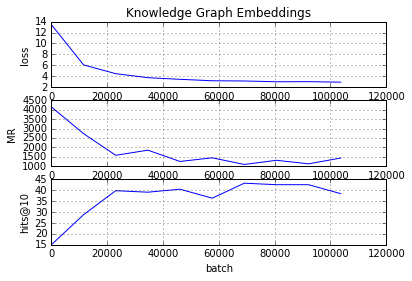

In [4]:
# embeddings = pd.read_csv(base_path + 'Embeddings/entity_embeddings_last_cleaned.csv')
# here, we exclude mainly the data properties from the KG embeddings
# and consistsOf, since this is not given for unlabeled routings
excluded_rels = ['http://www.siemens.com/knowledge_graph/ppr#resourceName',
                     'http://www.siemens.com/knowledge_graph/ppr#shortText',
                     'http://www.siemens.com/knowledge_graph/ppr#compVariant',
                     'http://www.siemens.com/knowledge_graph/ppr#compVersion',
                     'http://www.siemens.com/knowledge_graph/ppr#personTime_min',
                     'http://www.siemens.com/knowledge_graph/ppr#machiningTime_min',
                     'http://www.siemens.com/knowledge_graph/ppr#setupTime_min',
                     'http://www.siemens.com/knowledge_graph/ppr/ind#train',
                     'http://www.siemens.com/knowledge_graph/ppr/ind#predict',
                     'http://siemens.com/knowledge_graph/industrial_upper_ontology#hasPart',
                    RDF.type,
                     'http://siemens.com/knowledge_graph/cyber_physical_systems/industrial_cps#consistsOf',
                    ]

embedding_size = 120
num_epochs = 50
batch_size = 32
learning_rate = 0.1
validation_size = 0.001

ekl_learning = EKLBaseExperiment(TranslationModels.Trans_E, path_to_kg, embedding_size, num_epochs,
                                 batch_size, learning_rate, validation_size)
embeddings = ekl_learning.run(excluded_rels)
ekl_learning.plot_model_summary()

In [92]:
def type_filter(label):
    label = unicode(label)
    if '0' in label:
        return True
    elif 'Z_Dummy' in label:
        return True
    elif 'nan' in label:
        return True
    elif '?' in label:
        return True
    return False


def get_data(level):
    data = []
    labels = []
    for ent in pl3_train_ents:
        types = get_type(ent, g_all)
        type_x = types[3 - level]
        # for type 2 and 3 remove respectively
        if level == 2:
            type_x = type_x.replace(types[2], '')
        if level == 3:
            type_x = type_x.replace(types[1], '')
        if type_filter(type_x):
            continue
        values = embeddings[embeddings['uri'] == unicode(ent)].values
        if values.shape[0] == 1:
            embedding = values[0, :-1]
            data.append(embedding)
            labels.append(type_x)
        else:
            continue
    return np.array(data), np.array(labels)


def prepare_train_test(data, labels):
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    le = preprocessing.LabelEncoder()
    le.fit(unique_labels)
    one_hot_labels = keras.utils.to_categorical(le.transform(labels), num_classes=num_classes)
    train_data, test_data, train_labels, test_labels =  train_test_split(data, one_hot_labels, test_size=0.2, random_state=42)
    
    print 'Train: ', train_data.shape, train_labels.shape
    print 'Test: ', test_data.shape, test_labels.shape
    print 'Num classes: ', num_classes
    
    return train_data, test_data, train_labels, test_labels, unique_labels, num_classes, le


def train_model(hidden_layer_size, num_epochs, num_classes):
    model = Sequential()
    model.add(Dense(hidden_layer_size, activation='relu', input_dim=embedding_size))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_data, train_labels, validation_split=0.1, epochs=num_epochs, batch_size=32, verbose=0)
    return model, history


def plot_model_history(history, metric='acc', savefig=False):
    fig = plt.Figure(dpi=80)
    if metric == 'acc':
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
    else:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    if savefig:
        fig.savefig(metric + '.png')
    else:
        plt.show()

In [130]:
level = 1
data, labels = get_data(level)
train_data, test_data, train_labels, test_labels, unique_labels, num_classes, le = prepare_train_test(data, labels)

Train:  (6568, 120) (6568, 17)
Test:  (1642, 120) (1642, 17)
Num classes:  17


In [131]:
hidden_layer_size = 100
num_epochs = 120
model, history = train_model(hidden_layer_size, num_epochs, num_classes)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 100)               12100     
_________________________________________________________________
dense_42 (Dense)             (None, 17)                1717      
Total params: 13,817
Trainable params: 13,817
Non-trainable params: 0
_________________________________________________________________
None


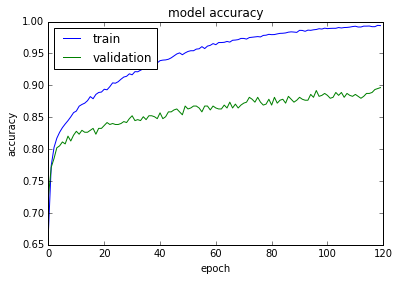

In [132]:
plot_model_history(history, metric='acc')

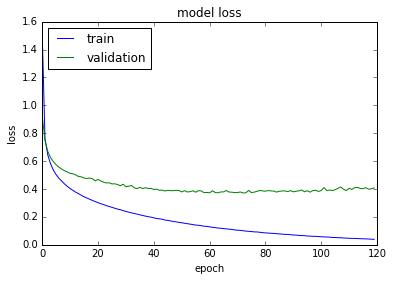

In [133]:
plot_model_history(history, metric='loss')

In [134]:
final_loss, final_acc = model.evaluate(test_data, test_labels, batch_size=32, verbose=0)
print "Test Acurracy: %.2f prct" %final_acc

Test Acurracy: 0.92 prct


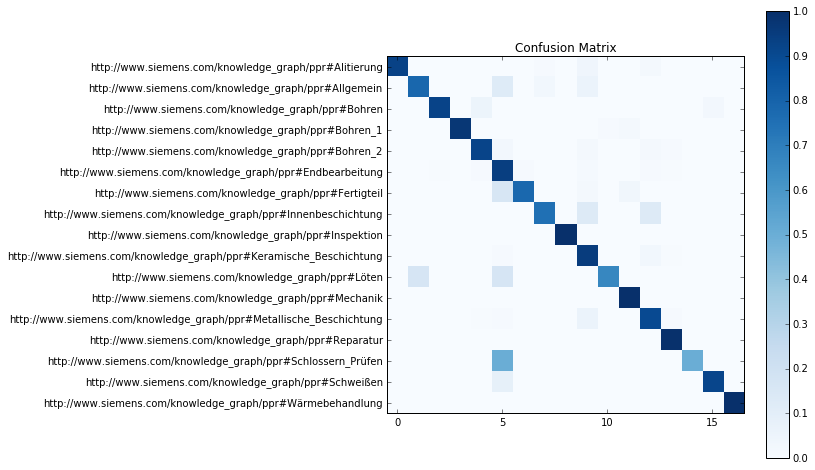

In [135]:
# demo_entity = u'http://www.siemens.com/knowledge_graph/ppr/ind#PG0040948000-10-Mechanik_Schleifen_1_Schleifen_Laufschaufel-2'
predicted = []
actual = []
for demo_entity in pl3_train_ents:
    actual_type = get_type(demo_entity, g_all)[3 - level]
    if type_filter(actual_type):
        continue
    try:
        values = embeddings[embeddings['uri'] == unicode(demo_entity)].values[0,:-1]
    except:
        continue
    classe = np.argmax(model.predict(values.reshape((1, embedding_size)), batch_size = 1))
    actual.append(actual_type)
    predicted.append(le.inverse_transform(classe))
cm = confusion_matrix(actual, predicted, labels=unique_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (8, 8), dpi=180)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
# plt.yticks(tick_marks, [l.split('#')[1] for l in unique_labels])
plt.yticks(tick_marks, unique_labels)
plt.show()
#plt.savefig("confusion_level" + str(level) + ".svg")

In [136]:
level = 2
data, labels = get_data(level)
train_data, test_data, train_labels, test_labels, unique_labels, num_classes, le2 = prepare_train_test(data, labels)

Train:  (6543, 120) (6543, 44)
Test:  (1636, 120) (1636, 44)
Num classes:  44


In [137]:
hidden_layer_size = 100
num_epochs = 120
model2, history = train_model(hidden_layer_size, num_epochs, num_classes)
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 100)               12100     
_________________________________________________________________
dense_44 (Dense)             (None, 44)                4444      
Total params: 16,544
Trainable params: 16,544
Non-trainable params: 0
_________________________________________________________________
None


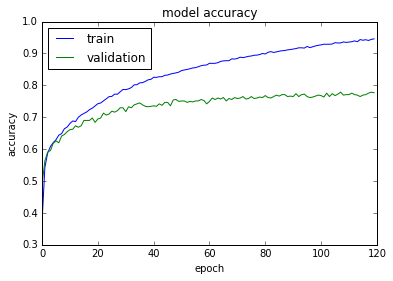

In [138]:
plot_model_history(history, metric='acc')

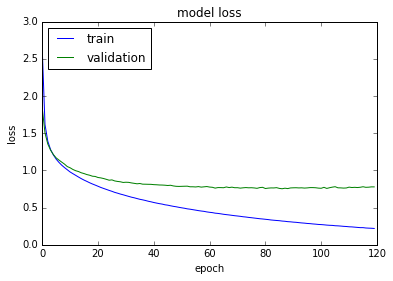

In [139]:
plot_model_history(history, metric='loss')

In [140]:
final_loss, final_acc = model2.evaluate(test_data, test_labels, batch_size=32, verbose=0)

print "Test Acurracy: %.2f prct" %final_acc

Test Acurracy: 0.77 prct


In [141]:
level = 3
data, labels = get_data(level)
train_data, test_data, train_labels, test_labels, unique_labels, num_classes, le3 = prepare_train_test(data, labels)

Train:  (6413, 120) (6413, 170)
Test:  (1604, 120) (1604, 170)
Num classes:  170


In [146]:
hidden_layer_size = 170
num_epochs = 80
model3, history = train_model(hidden_layer_size, num_epochs, num_classes)
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 170)               20570     
_________________________________________________________________
dense_48 (Dense)             (None, 170)               29070     
Total params: 49,640
Trainable params: 49,640
Non-trainable params: 0
_________________________________________________________________
None


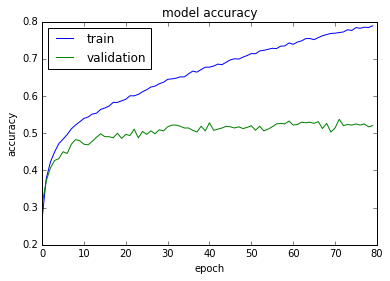

In [147]:
plot_model_history(history, metric='acc')

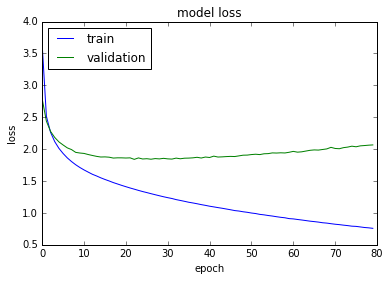

In [148]:
plot_model_history(history, metric='loss')

In [149]:
final_loss, final_acc = model3.evaluate(test_data, test_labels, batch_size=32, verbose=0)
print "Test Acurracy: %.2f prct" %final_acc

Test Acurracy: 0.49 prct


In [167]:
output_g = ConjunctiveGraph()
excel_array = []

for demo_entity in pl3_test_ents:
    # exclude the empty entity?
    if demo_entity == 'http://www.siemens.com/knowledge_graph/ppr/ind':
        continue
    try:
        values = embeddings[embeddings['uri'] == unicode(demo_entity)].values[0,:-1]
    except:
        continue
    type_1 = np.argmax(model.predict(values.reshape((1, embedding_size)), batch_size = 1))
    type_2 = np.argmax(model2.predict(values.reshape((1, embedding_size)), batch_size = 1))
    type_3 = np.argmax(model3.predict(values.reshape((1, embedding_size)), batch_size = 1))
    uri_1 = le.inverse_transform(type_1) 
    uri_2 = le2.inverse_transform(type_2)
    uri_3 = le3.inverse_transform(type_3)
    
    output_g.add( (URIRef(demo_entity), RDF.type, URIRef(''.join([uri_1, uri_2, uri_3]))) )
    
    splitted_mm_uri = demo_entity.split('-')
    mm_uri = splitted_mm_uri[0]
    step = splitted_mm_uri[1]
    
    excel_array.append([mm_uri.split('#')[1], step, uri_1.split('#')[1], uri_2.replace('_', ''), uri_3.replace('_', '')])
    
print(len(output_g))
df = pd.DataFrame(excel_array)
df.to_csv('test.csv', header = ['mm_uri', 'Step', 'PL1', 'PL2', 'PL3'], encoding='utf-8')

11218


In [168]:
output_g.serialize('classified_routings.rdf')